In [13]:
# Install requirements 
!pip install python-igraph
!pip install xlrd
!pip install gspan-mining
!pip install gspan
!pip install --upgrade beautifulsoup4
!pip install --upgrade html5lib
!pip install --upgrade html5lib==1.0b8

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Using cached https://files.pythonhosted.org/packages/21/0a/47fdf541c97fd9b6a610cb5fd518175308a7cc60569962e776ac52420387/beautifulsoup4-4.6.3-py3-none-any.whl
  Found existing installation: beautifulsoup4 4.4.1
    Uninstalling beautifulsoup4-4.4.1:
      Successfully uninstalled beautifulsoup4-4.4.1


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Using cached https://files.pythonhosted.org/packages/a5/62/bbd2be0e7943ec8504b517e62bab011b4946e1258842bc159e5dfde15b96/html5lib-1.0.1-py2.py3-none-any.whl
Requirement already up-to-date: webencodings in d:\anaconda\lib\site-packages (from html5lib)
Requirement already up-to-date: six>=1.9 in d:\anaconda\lib\site-packages (from html5lib)
  Found existing installation: html5lib 1.0b8
    Uninstalling html5lib-1.0b8:
      Successfully uninstalled html5lib-1.0b8


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Requirement already up-to-date: six in d:\anaconda\lib\site-packages (from html5lib==1.0b8)
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [19]:
import pandas as pd
import math
import numpy as np
import igraph
import os

def xlsx_to_gml(filename):
    #read xlsx file into dataframe
    #print(filename)

    post_df = pd.read_excel(filename)
    #list to add comment ids that were deleted for some reason

    #creating a root node
    root = {'id' : filename[len(filename)-11:len(filename)-5]}
    root_df = pd.DataFrame(root,index = ['0'])
    
    
    post_df = pd.concat([root_df,post_df],ignore_index=True)
    
    #fix to add columns if they are not in the xlsx file
    if 'attachments' not in post_df.columns:
        post_df['attachments'] = ''
    if 'reply_to_comment' not in post_df.columns:
        post_df['reply_to_comment'] = 0
    if 'reply_to_user' not in post_df.columns:
        post_df['reply_to_user'] = 0
    
    met_id = list()

    for comment in post_df.iterrows():
        if ( (not math.isnan(comment[1]['reply_to_comment'])) and 
            (comment[1]['reply_to_comment'] not in met_id) and
            (comment[1]['reply_to_comment'] not in post_df['id'].tolist()) ):
                met_id.append(comment[1]['reply_to_comment'])
                
    
    met_id_df = pd.DataFrame({'id' : met_id})
    
    #adding empty rows with id field so that every comment id mentioned in xlsx gets its node.
    post_df = pd.concat([post_df,met_id_df],ignore_index=True)

    

    post_Graph = igraph.Graph(directed=True)
    post_Graph.add_vertices(len(post_df)) #all comments get a node + root node for the post itself

    #filling graph vertices with xlsx content
    post_Graph.vs['attachments'] = post_df['attachments'].fillna('').apply(str).tolist()
    post_Graph.vs['date'] = post_df['date'].fillna(0).apply(int).apply(lambda x: x if x > 0 else '').apply(str).tolist()
    post_Graph.vs['from_id'] = post_df['from_id'].fillna(0).apply(int).apply(lambda x: x if x > 0 else '').apply(str).tolist()
    post_Graph.vs['comment_id'] = post_df['id'].fillna(0).apply(int).apply(lambda x: x if x > 0 else '').apply(str).tolist()
    post_Graph.vs['reply_to_comment'] = post_df['reply_to_comment'].fillna(0).apply(int).apply(lambda x: x if x > 0 else '').apply(str).tolist()
    post_Graph.vs['reply_to_user'] = post_df['reply_to_user'].fillna(0).apply(int).apply(lambda x: x if x > 0 else '').apply(str).tolist()
    post_Graph.vs['text'] = post_df['text'].fillna('').apply(str).tolist()
    post_Graph.vs['intent'] = post_df['Intent'].fillna('').apply(str).tolist()
    post_Graph.vs['content'] = post_df['Content'].replace(' -',float('NaN')).fillna('').apply(str).tolist()
    post_Graph.vs['intervention'] = post_df['Intervention'].fillna('').apply(str).tolist()
    
    
    #creating graph edges between comments
    for comment in post_df.iterrows():
        if ( (math.isnan(comment[1]['reply_to_comment']))):
            post_Graph.add_edge(0,comment[0])
        else:
            for replied_comment in post_df.iterrows():
                if (replied_comment[1]['id'] == comment[1]['reply_to_comment']):
                    post_Graph.add_edge(replied_comment[0], comment[0])
    
    
    #post_Graph.write_gml( ('C:/Users/Tamir/Desktop/HSE_Project/gml_from_excel/' + filename[47:len(filename)-5] + '.gml').replace(' ','').replace('\\','/').replace('//','/'))
    #post_Graph.write_gml('drive/gml_from_excel/' + '25106701_437551' +'.gml')
    #print('gml is done')
    return post_Graph

In [20]:
def intervention_subgraph_search(post_Graph):
    intervention_subgraphs = list()
    #print(post_Graph.subgraph( (3,4,7,8) ))
    for v in post_Graph.vs.select(intervention_ne=''):
        #print('Intervention node for subgraph: ' + str(v.index))
        subgraph_vertices = list()
        #print('Its predeccessors: ' + str(v.predecessors()))
        if ( v.predecessors()[0]['intent'] != ''):
            subgraph_vertices.append(v.predecessors()[0].index)
        subgraph_vertices.append(v.index)
        neighbors = list()
        neighbors.extend(v.successors())
        #print('Its successors: ' + str(neighbors))
        #print('Constructing subgraph...')
        while len(neighbors) > 0:
            for neighbor in neighbors:
                #print(neighbor.index)
                neighbors.extend(neighbor.successors())
                subgraph_vertices.append(neighbor.index)
                neighbors.remove(neighbor)
        #print(subgraph_vertices)
        intervention_subgraphs.append(post_Graph.subgraph(subgraph_vertices))
    return intervention_subgraphs

In [21]:
def generalize_intent(intervention_subgraphs):

    
    intent_generalization = {"I": ["А", "Б", "В", "Г", "Д"],  # Информативно-воспроизводящий
                                   "E": ["Е", "Ж", "З", "И", "К"],  # Эмотивно-консолидирующий
                                   "M": ["Л", "М", "Н", "О", "П"],  # Манипулятивный тип, доминирование
                                   "D": ["Р", "С", "Т", "У", "Ф"],  # Волюнтивно-директивный
                                   "R": ["Х", "Ц", "Ч", "Ш", "Щ"]}  # Контрольно-реактивный
    #rint(list(intent_generalization.values()))
    for subgraph in intervention_subgraphs:
        for v in subgraph.vs:
            for general_letter,intent_list in intent_generalization.items():
              
                if ((v['intent'].split(', ')[0][0]) in intent_list):
                    subgraph_intent = general_letter
            v['intent'] = subgraph_intent
    for subgraph in intervention_subgraphs:
        if (subgraph.vcount() > 1):
            if(  ((subgraph.vs[0]['intent'] == 'I') and (subgraph.vs[0]['intervention'] != '')) or ((subgraph.vs[1]['intent'] == 'I') and (subgraph.vs[1]['intervention'] != '')) ):
                I_subgraphs.append(subgraph)
            if(  ((subgraph.vs[0]['intent'] == 'E') and (subgraph.vs[0]['intervention'] != '')) or ((subgraph.vs[1]['intent'] == 'E') and (subgraph.vs[1]['intervention'] != ''))):
                E_subgraphs.append(subgraph)
            if(  ((subgraph.vs[0]['intent'] == 'M') and (subgraph.vs[0]['intervention'] != '')) or ((subgraph.vs[1]['intent'] == 'M') and (subgraph.vs[1]['intervention'] != ''))):
                M_subgraphs.append(subgraph)
            if(  ((subgraph.vs[0]['intent'] == 'D') and (subgraph.vs[0]['intervention'] != '')) or ((subgraph.vs[1]['intent'] == 'D') and (subgraph.vs[1]['intervention'] != ''))):
                D_subgraphs.append(subgraph)
            if(  ((subgraph.vs[0]['intent'] == 'R') and (subgraph.vs[0]['intervention'] != '')) or ((subgraph.vs[1]['intent'] == 'R') and (subgraph.vs[1]['intervention'] != ''))):
                R_subgraphs.append(subgraph)
        else:
            if (subgraph.vs[0]['intent'] == 'I'):
                I_subgraphs.append(subgraph)
            if (subgraph.vs[0]['intent'] == 'E'):
                E_subgraphs.append(subgraph)
            if (subgraph.vs[0]['intent'] == 'M'):
                M_subgraphs.append(subgraph)
            if (subgraph.vs[0]['intent'] == 'D'):
                D_subgraphs.append(subgraph)
            if (subgraph.vs[0]['intent'] == 'R'):
                R_subgraphs.append(subgraph)                
    return I_subgraphs,E_subgraphs,M_subgraphs,D_subgraphs,R_subgraphs

In [22]:
def make_data_file(graphs,mark):
    log = ""
    counter = 0
    for graph in graphs:
        log = log + "t # " + str(counter) + "\n"
        for vertex in graph.vs:
            log = log + "v " + str(vertex.index) + " " + str(vertex['intent']) + "\n"
        for edge in graph.es:
            log = log + "e " + str(edge.source) + " " + str(edge.target) + " " + "1" + "\n"
        counter = counter + 1
    with open('C:/Users/Tamir/Desktop/HSE_Project/' + mark + '_input_data.data', 'w',encoding="utf-8") as the_file:
        the_file.write(log)

def gspan_use(graphs,mark):
    
    make_data_file(graphs,mark)
    args_str = '-s 5 -d True -l 2 -p True -w True C:/Users/Tamir/Desktop/HSE_Project/' + mark + '_input_data.data'
    FLAGS, _ = parser.parse_known_args(args=args_str.split())
    print('ANALYSING ' + mark + ' DATA INPUT FILE')
    gs = main(FLAGS)
    gs._report_df.to_csv( 'C:/Users/Tamir/Desktop/HSE_Project/' + mark + '_input_data.csv' )

Populating the interactive namespace from numpy and matplotlib
ANALYSING I DATA INPUT FILE
t # 0
v 0 E
v 1 I
e 0 1 1

Support: 9


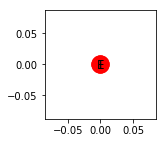

where: [0, 3, 4, 5, 6, 7, 13, 15, 18]

-----------------

t # 1
v 0 I
v 1 E
e 0 1 1

Support: 8


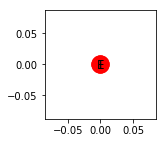

where: [0, 3, 6, 7, 9, 11, 12, 13]

-----------------

t # 2
v 0 R
v 1 I
e 0 1 1

Support: 5


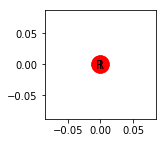

where: [1, 3, 6, 13, 19]

-----------------

Read:	0.0 s
Mine:	0.27 s
Total:	0.27 s
ANALYSING E DATA INPUT FILE
t # 0
v 0 E
v 1 E
e 0 1 1

Support: 21


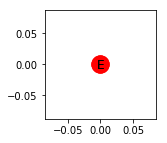

where: [8, 9, 11, 13, 14, 21, 24, 26, 27, 40, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57]

-----------------

t # 1
v 0 E
v 1 E
v 2 E
e 0 1 1
e 1 2 1

Support: 8


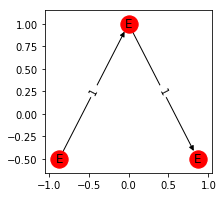

where: [40, 45, 46, 47, 48, 54, 55, 56]

-----------------

t # 2
v 0 E
v 1 E
v 2 E
v 3 E
e 0 1 1
e 1 2 1
e 2 3 1

Support: 7


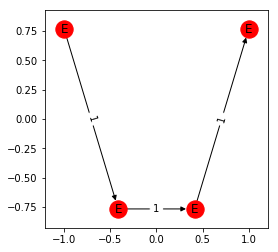

where: [45, 46, 47, 48, 54, 55, 56]

-----------------

t # 3
v 0 E
v 1 E
v 2 E
v 3 E
v 4 E
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


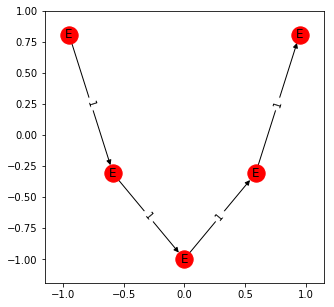

where: [45, 46, 47, 54, 55]

-----------------

Read:	0.0 s
Mine:	0.42 s
Total:	0.42 s
ANALYSING M DATA INPUT FILE
Read:	0.0 s
Mine:	0.0 s
Total:	0.0 s
ANALYSING D DATA INPUT FILE
Read:	0.0 s
Mine:	0.0 s
Total:	0.0 s
ANALYSING R DATA INPUT FILE
t # 0
v 0 E
v 1 R
e 0 1 1

Support: 18


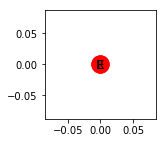

where: [0, 66, 67, 68, 37, 69, 7, 40, 70, 10, 42, 43, 45, 46, 54, 55, 25, 28]

-----------------

t # 1
v 0 E
v 1 R
v 2 E
e 0 1 1
e 1 2 1

Support: 7


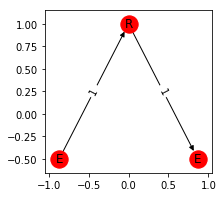

where: [0, 66, 67, 68, 69, 45, 54]

-----------------

t # 2
v 0 R
v 1 E
e 0 1 1

Support: 10


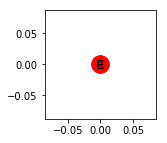

where: [0, 33, 66, 67, 68, 69, 45, 13, 21, 54]

-----------------

t # 3
v 0 R
v 1 R
e 0 1 1

Support: 11


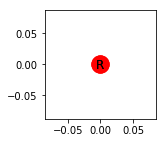

where: [64, 65, 6, 7, 11, 13, 14, 78, 83, 60, 61]

-----------------

Read:	0.0 s
Mine:	0.35 s
Total:	0.35 s


In [23]:
#RUN THIS
from gspan_mining.config import parser
from gspan_mining.main import main
%pylab inline
import os
filenames = list()
intervention_subgraphs = list()
for directory, subdirectories, files in os.walk('C:/Users/Tamir/Desktop/HSE_Project/excel_files/'):
    for file in files:
        filenames.append(os.path.join(directory,file))
for filename in filenames:
    if (filename[len(filename) - 22] == '~'):
        continue
    filename = filename.replace(" ", " ")
    post_Graph = xlsx_to_gml(filename)
    intervention_subgraphs.extend(intervention_subgraph_search(post_Graph))

I_subgraphs = list()
E_subgraphs = list()
M_subgraphs = list()
D_subgraphs = list()
R_subgraphs = list()

I_subgraphs, E_subgraphs, M_subgraphs,D_subgraphs,R_subgraphs = generalize_intent(intervention_subgraphs)

gspan_use(I_subgraphs,'I')
gspan_use(E_subgraphs,'E')
gspan_use(M_subgraphs,'M')
gspan_use(D_subgraphs,'D')
gspan_use(R_subgraphs,'R')






In [4]:
#to install python-igraph on windows download .whl file and run this command.
#.whl file differs depending on your python version
!python -m pip install python_igraph-0.7.1.post6-cp36-cp36m-win_amd64.whl

Processing c:\users\tamir\python_igraph-0.7.1.post6-cp36-cp36m-win_amd64.whl


You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
